<h1 style="text-align: center; font-weight: bold">Training - Pipeline</h1>

---

# 1 - Notebook Setup

## 1.1 - Imports

In [37]:
# system
from IPython.display import clear_output

import sys
sys.path[0] = sys.path[0].replace('notebooks', '')

# visualization
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

# model
from model import ChatBot

import torch.optim as optim

# data manipulation
from torch.utils.data import random_split, Dataset, DataLoader
from nltk.corpus import stopwords
from string import punctuation
from pathlib import Path

import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import json
import os
import re

## 1.2 - Dataset path

In [2]:
try:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    df_path = Path('/content/gdrive/MyDrive/')
    figure_path = Path('/content')
    weight_path = Path('/content/gdrive/MyDrive/')
    ENV = 'Google Colab'
except Exception as error:
    df_path = Path(os.getcwd().replace('notebooks', 'data/processed'))
    figure_path = Path(os.getcwd().replace('notebooks', 'figures'))
    weight_path = Path(os.getcwd().replace('notebooks', 'model')).joinpath('weights')
    weight_path.mkdir(exist_ok=True)
    ENV = 'Local Machine'

print(f'[\033[1;33mENVIRONMENT\033[0m]: {ENV}')
print(f'Dataset located in {df_path}')

[ENVIRONMENT]: Local Machine
Dataset located in c:\Users\Matheus\WorkSpace\ChatBot\data\processed


## 1.3 - Device (GPU|CPU)

In [3]:
device = torch.device(device='cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    gpu_available = '\033[1;32mAvailable\033[0m'
else:
    gpu_available = '\033[1;31mNot Available\033[0m'
print(f'[\033[1;36mGPU\033[0m]: {gpu_available}')

[GPU]: Available


# 2 - Custom Dataset

## 2.1 - Loading dataset

In [4]:
data_frame = pd.read_csv(df_path.joinpath('cleaned_dataframe.csv'), encoding='utf-8', delimiter=",", on_bad_lines='skip')
with open(file=df_path.joinpath('data_info.json'), mode='r') as json_file:
    json_content = json.load(fp=json_file)
    word_dict = json_content['word_dict']
    question_len = json_content['question_length']
    answer_len = json_content['answer_length']
    vocabulary = json_content['num_vocabulary']
    word_dict_num = {v: k for k, v in word_dict.items()}

In [5]:
data_frame.head(5)

,question,answers
0,first work generally recognized artificial int...,warren mcculloch and walter pitts 1943
1,sources drawn formation first work generally r...,knowledge of the basic physiology and function...
2,created hebbian learning rule,donald hebb 1949
3,first neural network built,1950
4,first neural network called,the snarc


## 2.2 - Splitting dataset

In [6]:
cleaned_dataframe_np = np.asarray(a=data_frame)

split_size = [0.8, 0.1, 0.1]
train_split, test_split, valid_split = random_split(dataset=cleaned_dataframe_np, lengths=split_size)

In [7]:
train_df = cleaned_dataframe_np[train_split.indices]
test_df = cleaned_dataframe_np[test_split.indices]
valid_df = cleaned_dataframe_np[valid_split.indices]

In [8]:
for df_name, data in zip(['train', 'test', 'valid'], [train_df, test_df, valid_df]):
    print(f'{df_name:5}: {data.shape}')

train: (3377, 2)
test : (422, 2)
valid: (422, 2)


## 2.3 - Creating custom dataset class

In [9]:
class CustomDataset(Dataset):

    def __init__(self, dataset: np.ndarray, word_dict: dict, voc_size: int, max_len_in: int = 30, max_len_out: int = 500) -> None:
        
        self.x = dataset[:,0]
        self.y = dataset[:,1]

        self.wd = word_dict
        self.vs = voc_size
        self.mli = max_len_in
        self.mlo = max_len_out
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, index: int) -> torch.Tensor:
        
        x = self.x[index]
        y = self.y[index]

        x, y = self.gen_data(x=x, y=y)
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        return x, y
    
    def gen_data(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:

        x_data = []
        y_data = []

        x_data.append(self.wd['<start>'])
        for word in x.split(' '):
            x_data.append(self.wd[word])
        x_data.append(self.wd['<stop>'])
        while len(x_data) < self.mli:
            x_data.append(self.wd['<pad>'])
        x_data = np.asarray(a=x_data)

        y_data.append(self.wd['<start>'])
        for word in y.split(' '):
            y_data.append(self.wd[word])
        y_data.append(self.wd['<stop>'])
        while len(y_data) < self.mlo:
            y_data.append(self.wd['<pad>'])
        y_data = np.asarray(a=y_data)

        return x_data, y_data

In [10]:
train_custom_df = CustomDataset(dataset=train_df, word_dict=word_dict, voc_size=vocabulary, max_len_in=question_len, max_len_out=answer_len)
test_custom_df = CustomDataset(dataset=test_df, word_dict=word_dict, voc_size=vocabulary, max_len_in=question_len, max_len_out=answer_len)
valid_custom_df = CustomDataset(dataset=valid_df, word_dict=word_dict, voc_size=vocabulary, max_len_in=question_len, max_len_out=answer_len)

In [11]:
for x, y in test_custom_df:
    print(f'X: {x.size()}')
    print(f'Y: {y.size()}')
    break

X: torch.Size([30])
Y: torch.Size([400])


# 3 - Model

In [12]:
model = ChatBot(out_shape=(vocabulary, answer_len), word_dict=word_dict, device=device)

## 3.1 - Checking architecture

In [13]:
build = model(
    torch.zeros(size=(2,question_len)).to(device=device),
    torch.zeros(size=(2,answer_len)).to(device=device)
)
build.size()

torch.Size([2, 5249, 399])

# 4 - Training

## 4.1 - Variables

### 4.1.1 - Training parameters

In [14]:
epochs = 100
batch_size = 32
lr = 1e-3
early_stop = 5

n_plots = 10

### 4.1.2 - Initializing weights

In [15]:
def _init_weights(module) -> None:
    if isinstance(module, (nn.Linear, nn.Embedding)):
        module.weight.data.normal_(mean=0, std=0.02)

In [16]:
model.apply(_init_weights)

ChatBot(
  (q_emb): Embedding(5249, 399)
  (q_lstm): LSTM(399, 512, batch_first=True)
  (q_lin): Linear(in_features=512, out_features=256, bias=True)
  (a_emb): Embedding(5249, 399)
  (a_lstm): LSTM(655, 512)
  (lin): Linear(in_features=512, out_features=5249, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
)

### 4.1.3 - Loss function

In [17]:
loss_fn = nn.CrossEntropyLoss(ignore_index=word_dict['<pad>'])

### 4.1.4 - Optimizer

In [18]:
optimizer = optim.Adam(model.parameters(), lr=lr)

## 4.2 - Training methods

In [19]:
def plot_train_loss(loss: list, val_loss: list, epoch: int) -> None:
    
    fig, ax = plt.subplots(figsize=(10,4))

    for data, label in [(loss, 'train'), (val_loss, 'valid')]:
        try:
            ax.plot(np.arange(stop=epoch, step=epoch / len(data)), data, label=label)
        except:
            ax.plot(np.arange(stop=epoch, step=epoch / (len(data) - 0.5)), data, label=label)
    
    ax.set_xticks(np.arange(start=1, stop=epoch + 1))
    ax.set_title(label='Loss graph', fontdict={'size': 10})

    plt.legend(loc='upper right')
    plt.show()

## 4.3 - Creating dataloaders

In [20]:
train_loader = DataLoader(dataset=train_custom_df, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_custom_df, batch_size=batch_size, shuffle=True)

## 4.4 - Training loop

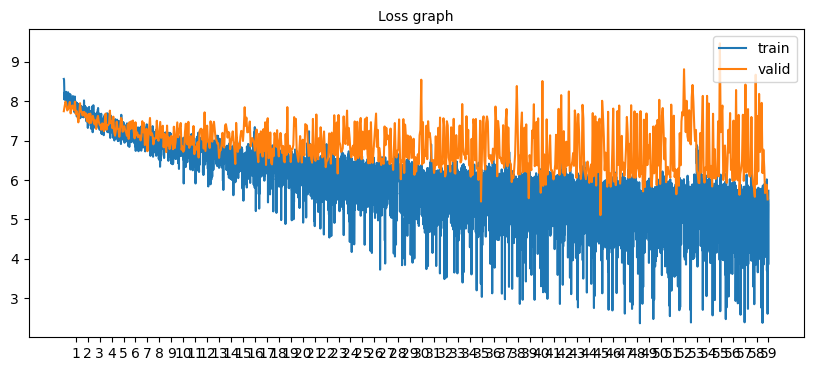

question  : thought playing dome
answer    : the dome doesnt close
predict   : dynamic economyhamburg harmless harmless harmless shells standing fault fault fault honk honk faucet faucet faucet surrounded dininggeneva dininggeneva dininggeneva surrounded surrounded surrounded surrounded surrounded surrounded surrounded surrounded surrounded surrounded invited invited general general follows voter voter voter voter voter 1 1 1 1 1 blind blind blind blind blind cabinet cabinet cabinet cabinet cabinet puff puff puff again initially general general general general universitiesxian preceptrons preceptrons preceptrons requirements effects effects tuesday tuesday tuesday tuesday generally generally tuesday tuesday tuesday tuesday till metaphor metaphor metaphor metaphor metaphor metaphor metaphor umbrella robber warren symbol symbol symbol sick sick sick sick sick putting putting putting s s s s false boxes boxes boxes backs backs backs backs backs backs backs backs backs backs backs backs ba

Loss: 5.395688056945801:   1%|          | 1/106 [00:07<13:29,  7.71s/it]


KeyboardInterrupt: 

In [21]:
train_losses = []
valid_losses = []

best_loss = float('inf')
best_epoch = 'No saved yet'

previous_train = float('inf')
previous_valid = float('inf')

valid_x = []
valid_y = []
valid_yhat = []

overfitting = 0


for curr_epoch in range(1, epochs+1):

    print(f'Epoch: {curr_epoch}/{epochs} | Batch: {batch_size} | Learing Rate: {lr} | Loss Function: {loss_fn.__class__.__name__} | Optimizer: {optimizer.__class__.__name__}')
    print(f'Overtting: {overfitting}/{early_stop} | Best loss: {best_loss} - Last savement: {best_epoch}')

    if overfitting == early_stop:
        print('\033[1;31mOVERFITTING\033[0m')
        break

    # training
    train_iter = tqdm(iterable=train_loader)
    train_loss = 0
    model.train()
    for x, y in train_iter:

        x = x.to(device=device)
        y = y.to(device=device)

        yhat = model(x, y.long())

        loss = loss_fn(yhat.view(-1, vocabulary), y[:,1:].reshape(-1).long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # saving train results
        train_losses.append(loss.cpu().detach().numpy())
        train_iter.set_description(desc=f'Loss: {loss.item()}')
        train_loss += loss.item()

        del x, y, yhat, loss

    train_loss /= len(train_loader)

    # validing
    valid_x.clear()
    valid_y.clear()
    valid_yhat.clear()
    valid_iter = tqdm(iterable=valid_loader)
    valid_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in valid_iter:

            x = x.to(device=device)
            y = y.to(device=device)

            yhat = model(x, y.long())

            loss = loss_fn(yhat.view(-1, vocabulary), y[:,1:].reshape(-1).long())

            # saving valid results
            valid_losses.append(loss.cpu().detach().numpy())
            valid_iter.set_description(desc=f'Valid loss: {loss.item()}')
            valid_loss += loss.item()

            # saving samples
            if len(valid_x) < n_plots:
                if np.random.random() > .7:

                    rand_idx = np.random.choice(a=x.size(0), size=1).item()

                    valid_x.append(x[rand_idx,:].unsqueeze(0).cpu())
                    valid_y.append(y[rand_idx,:].unsqueeze(0).cpu())
                    valid_yhat.append(yhat[rand_idx,:,:].unsqueeze(0).cpu().argmax(dim=1))
            
            del x, y, yhat, loss

    valid_loss /= len(valid_loader)
    
    # saving model
    if best_loss > valid_loss:
        best_loss = valid_loss
        best_epoch = curr_epoch
        torch.save(obj=model.state_dict(), f=weight_path.joinpath('chatbot_weights.pt'))
    
    # checking overfits
    if previous_train > train_loss and previous_valid < valid_loss:
        overfitting += 1
    else:
        if overfitting > 0:
            overfitting -= 1
    previous_train = train_loss
    previous_valid = valid_loss
    
    # plotting graphs
    clear_output()
    plot_train_loss(loss=train_losses, val_loss=valid_losses, epoch=curr_epoch)
    for x, y, yhat in zip(valid_x, valid_y, valid_yhat):
        for content, name in zip((x[0], y[0], yhat[0]), ('question', 'answer', 'predict')):
            text = []
            for values in content:
                word = word_dict_num[values.item()].replace('<start>', '').replace('<stop>', '').replace('<pad>', '')
                if len(word):
                    text.append(word)
            text = ' '.join(text).strip()
            print(f'{name:10}: {text}')
        print('-' * 50)

# 5 - Test

## 5.1 - Pretrained Model

In [ ]:
model = model.load_state_dict(state_dict=torch.load(f=weight_path.joinpath('chatbot_weights.pt')))
model.eval()

## 5.2 - Data Loader

In [22]:
test_loader = DataLoader(dataset=test_custom_df, batch_size=1)

In [33]:
for x, y in test_loader:
    
    x = x.to(device=device)
    y = y.to(device=device)
    
    yhat = model(x, y.long())
    
    for content, name in zip((x[0].cpu(), y[0].cpu(), yhat.cpu().argmax(dim=1)[0]), ('question', 'answer', 'predict')):
        text = []
        for values in content:
            word = word_dict_num[values.item()].replace('<start>', '').replace('<stop>', '').replace('<pad>', '')
            if len(word):
                text.append(word)
        text = ' '.join(text).strip()
        print(f'{name:10}: {text}')
    print('-' * 50)

question  : well english perfect
answer    : no one speaks perfect english
predict   : branching laxatives romaniabucharest harmless life standing standing ib heals honk honk honk worldrenowned taxes worldrenowned blow dininggeneva dininggeneva dininggeneva dininggeneva dininggeneva surrounded crazy crazy crazy drug crazy crazy surrounded crazy informal complex complex atmosphereutrecht mouth taste general rock guys voter voter voter gloves 1 1 1 1 1 1 1 blind blind blind blind cabinet cabinet 1 cabinet cabinet universitiesminneapolisst cabinet independently get get again found general general general reflex preceptrons preceptrons preceptrons effects add add tuesday generally tuesday till tuesday tuesday till metaphor metaphor metaphor metaphor metaphor metaphor metaphor themselves chore warren symbol symbol symbol sick sick feild sick sick putting putting false s s s s false boxes boxes backs backs backs backs backs backs backs backs backs backs backs algarve pineapples symbol backs 

KeyboardInterrupt: 

## 5.3 - Input text

In [48]:
def preprocessing_input(text: str) -> torch.Tensor:
    
    chars_filter = re.compile(pattern=r'''[.]*[(”?,:;"'“*)ºª!.-]+[.]*''')

    unwanted_chars = [
        '\'', 
        '\"',
        '/p',
        'ª',
        'º',
        '.',
        '!',
        '?',
        ',',
        ';',
        ':',
        '-',
        '\'',
        '!!',
        '``',
        '"'
        ]

    unwanted_words = [
        '\'s',
        "n't",
        '\'m',
        '\'ll',
        '\'re',
        'zzz',
        'b'
    ]

    replacement = {
        'bluedog123': 'blue dog 123',
        'csp': 'content security policy',
        'cant': 'can not',
        'zerosum': 'zero sum',
        'itll': 'it will',
        'ii': '2',
        'isnt': 'is not',
        'ill': 'i will',
        'id': 'i would',
        'im': 'i am',
        'ive': 'i have',
        'hes': 'he is',
        'shes': 'she is',
        'humanlevel': 'human level',
        'al': 'artificial inteligence',
        'ai': 'artificial inteligence',
        'funnylooking': 'funny looking'
    }

    stop_words = set(stopwords.words('english') + list(punctuation) + list(unwanted_chars) + list (unwanted_words))
    
    # normalizing text
    new_sentence = []
    sentence = text.strip().lower()
    # removing stop words
    for word in sentence.split(' '):
        curr_word_filter = chars_filter.search(string=word)
        while curr_word_filter:
            word = word.replace(curr_word_filter.group(0), '')
            curr_word_filter = chars_filter.search(string=word)
        if word in replacement:
            word = replacement[word].split(' ')
        if not isinstance(word, list):
            word = [word]
        for w in word:
            if w not in stop_words and w in word_dict:
                new_sentence.append(w)
    # checking if a sentence is
    # empty
    if not len(new_sentence):
        raise 'This is an invalid kind of question'
    
    x_data = []
    
    for word in new_sentence:
        x_data.append(word_dict[word])
    x_data.append(word_dict['<stop>'])
    while len(x_data) < question_len:
        x_data.append(word_dict['<pad>'])
    x_data = np.asarray(a=x_data)
    
    # converting to tensor
    x_data = torch.from_numpy(x_data) \
            .to(device=device) \
            .unsqueeze(dim=0)
    
    return x_data

In [49]:
input_text = 'Hello, my name is Matheus' # question

pred_answer = model.gen_text(question=preprocessing_input(text=input_text))
text = []
for values in pred_answer.cpu().argmax(dim=1):
    word = word_dict_num[values.item()].replace('<start>', '').replace('<stop>', '').replace('<pad>', '')
    if len(word):
        text.append(word)
text = ' '.join(text).strip()

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [50]:
preprocessing_input(text=input_text).size()

torch.Size([1, 30])